# BYM Prediction-Based FDR Simulation

This notebook runs a simulation study to estimate prediction-based False Discovery Rate (FDR) for a BYM model. In each simulation, we:
- Generate ground-truth patient and condition effects
- Mask a random fraction of observations
- Fit a BYM model on masked data (handling NaNs)
- Predict masked entries and compute FDR = FP / (FP + TP)

The final section summarizes the distribution of FDR across runs and visualizes it.


## Cell 1: Setup and Parameters

Imports core libraries (JAX, NumPy, NumPyro, SciPy/sklearn, Matplotlib) and defines:
- Simulation controls: number of simulations `N_sims`, patients `I`, conditions `C`, k-NN parameter `k`, masking fraction.
- Ground-truth parameters for data generation (`tau_s_true`, `tau_u_true`, `sigma_delta_true`).
- Sampler configuration (`num_warmup`, `num_samples`, `num_chains`).


In [ ]:
# Cell 1: Setup and Parameters
import os
import time

import jax
import jax.numpy as jnp
import numpy as np

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph

import matplotlib.pyplot as plt

# --- Simulation parameters ---
N_sims = 100  # number of simulation repetitions
I = 200       # number of patients
C = 50        # number of conditions
k = 10        # k for k-NN graph
masking_fraction = 0.2  # fraction of grid entries to mask

# --- True parameters for data generation ---
tau_s_true = 1.5       # structured precision
tau_u_true = 2.0       # unstructured precision
sigma_delta_true = 0.75  # std dev for condition effects
# Delta covariance parameters
sigma_delta_vec_true = jnp.array([0.8, 0.6, 0.9, 0.7, 0.5] + [0.75] * (C-5))  # condition-specific scales
delta_corr_true = jnp.eye(C)  # start with identity, will be modified in simulation

# --- Sampler parameters (exposed for runtime control) ---
num_warmup = 500
num_samples = 500
num_chains = 1

print("Simulation parameters set:", {
    'N_sims': N_sims,
    'I': I,
    'C': C,
    'k': k,
    'masking_fraction': masking_fraction,
    'tau_s_true': tau_s_true,
    'tau_u_true': tau_u_true,
    'sigma_delta_true': sigma_delta_true,
    'num_warmup': num_warmup,
    'num_samples': num_samples,
    'num_chains': num_chains,
})


Simulation parameters set: {'N_sims': 100, 'I': 200, 'C': 50, 'k': 10, 'masking_fraction': 0.2, 'tau_s_true': 1.5, 'tau_u_true': 2.0, 'sigma_delta_true': 0.75, 'num_warmup': 500, 'num_samples': 500, 'num_chains': 1}


## Cell 2: Helper Functions

- `get_laplacian_from_locs`: builds the patient k-NN graph and returns the graph Laplacian `L = D - W` as a JAX array.
- `bym_model`: a NumPyro BYM model with:
  - Structured component via `numpyro.factor` using the Laplacian energy `phi^T L phi` scaled by `tau_s`.
  - Unstructured component via `||phi||^2` scaled by `tau_u`.
  - Condition effects `delta` with prior scale `sigma_delta`.
  - Likelihood `Bernoulli(logits=phi[:,None]+delta[None,:])` masked to ignore `NaN` entries in `y`. 


In [ ]:
# Cell 2: Helper Functions
from numpyro import handlers


def get_laplacian_from_locs(locations: np.ndarray, k: int) -> jnp.ndarray:
    """
    Build an (I x I) graph Laplacian from 2D locations using k-NN adjacency.
    Returns a dense JAX array L = D - W.
    """
    I = locations.shape[0]
    # k-NN adjacency (exclude self-loops by setting include_self=False)
    A = kneighbors_graph(locations, n_neighbors=k, mode='connectivity', include_self=False)
    # Symmetrize
    W = (A + A.T).astype(bool).astype(np.float32)
    # Degree and Laplacian
    degrees = np.asarray(W.sum(axis=1)).ravel()
    D = np.diag(degrees)
    L = D - W.toarray()
    return jnp.asarray(L, dtype=jnp.float32)


def bym_model(L_pat: jnp.ndarray, y: jnp.ndarray, I: int, C: int):
    """
    NumPyro BYM model with NaN-masked observations and correlated delta effects.
    L_pat: (I x I) dense Laplacian
    y: (I x C) with NaNs indicating masked entries
    """
    # Hyperpriors
    tau_s = numpyro.sample("tau_s", dist.HalfCauchy(2.0))
    tau_u = numpyro.sample("tau_u", dist.HalfCauchy(2.0))
    
    # Hyperprior for delta covariance matrix
    # Use LKJ prior for correlation matrix and separate scale parameters
    sigma_delta_scale = numpyro.sample("sigma_delta_scale", dist.HalfCauchy(1.0))
    delta_corr = numpyro.sample("delta_corr", dist.LKJCholesky(C, concentration=1.0))
    
    # Construct covariance matrix: Sigma = diag(sigma_delta_scale) * R * diag(sigma_delta_scale)
    # where R is the correlation matrix from LKJ
    sigma_delta_vec = numpyro.sample("sigma_delta_vec", dist.HalfCauchy(1.0).expand([C]))
    delta_cov = jnp.outer(sigma_delta_vec, sigma_delta_vec) * delta_corr

    # Latents
    delta = numpyro.sample("delta", dist.MultivariateNormal(jnp.zeros(C), delta_cov))
    phi = numpyro.sample("phi", dist.Normal(0, 1.0).expand([I]))

    # Structured (ICAR-like) energy and unstructured energy
    U_structured = tau_s * (phi @ (L_pat @ phi))
    numpyro.factor("structured_effect", -0.5 * U_structured)

    U_unstructured = tau_u * jnp.sum(phi ** 2)
    numpyro.factor("unstructured_effect", -0.5 * U_unstructured)

    # Linear predictor
    Lambda = phi[:, None] + delta[None, :]

    # Likelihood with masking (mask True for observed entries)
    obs_mask = ~jnp.isnan(y)
    with handlers.mask(mask=obs_mask):
        numpyro.sample("obs", dist.Bernoulli(logits=Lambda), obs=y)


In [ ]:
# Cell 3: Main Simulation Loop

def sigmoid(x):
    return 1.0 / (1.0 + jnp.exp(-x))

fdr_results = []
# Parameter recovery tracking
param_recovery_results = {
    'tau_s_true': [],
    'tau_s_est': [],
    'tau_s_error': [],
    'tau_u_true': [],
    'tau_u_est': [],
    'tau_u_error': [],
    'sigma_delta_scale_true': [],
    'sigma_delta_scale_est': [],
    'sigma_delta_scale_error': [],
    'delta_corr_true': [],
    'delta_corr_est': [],
    'delta_corr_error': []
}
key = jax.random.PRNGKey(0)

for sim in range(N_sims):
    t0 = time.time()
    # --- Generate Ground Truth Data ---
    # Random 2D locations in unit square
    key, k_locs = jax.random.split(key)
    locations = jax.random.uniform(k_locs, shape=(I, 2), minval=0.0, maxval=1.0)
    locations_np = np.array(locations)

    # Build true patient Laplacian
    L_pat_true = get_laplacian_from_locs(locations_np, k)

    # Construct true precision Q_true = tau_s_true * L_pat_true + tau_u_true * I
    Q_true = tau_s_true * L_pat_true + (tau_u_true + 1e-5) * jnp.eye(I)

    # Sample phi_true ~ N(0, Q_true^{-1}) via Cholesky of Q_true
    # Solve Q_true^{-1/2} * z, with z ~ N(0, I)
    # Use symmetric PD assumption with jitter
    L_chol = jnp.linalg.cholesky(Q_true)
    key, k_z = jax.random.split(key)
    z = jax.random.normal(k_z, shape=(I,))
    # Solve L_chol x = z then L_chol^T phi = x => phi = (L_chol^{-T}) (L_chol^{-1}) z
    x = jax.scipy.linalg.solve_triangular(L_chol, z, lower=True)
    phi_true = jax.scipy.linalg.solve_triangular(L_chol.T, x, lower=False)

    # Condition effects with correlation structure
    # Generate a random correlation matrix for this simulation
    key, k_corr = jax.random.split(key)
    # Create a random positive definite matrix and normalize to correlation matrix
    A = jax.random.normal(k_corr, shape=(C, C))
    Sigma_temp = A @ A.T
    # Normalize to get correlation matrix
    diag_sqrt = jnp.sqrt(jnp.diag(Sigma_temp))
    delta_corr_true = Sigma_temp / jnp.outer(diag_sqrt, diag_sqrt)
    
    # Generate delta with correlated structure
    key, k_delta = jax.random.split(key)
    delta_cov_true = jnp.outer(sigma_delta_vec_true, sigma_delta_vec_true) * delta_corr_true
    delta_true = jax.random.multivariate_normal(k_delta, jnp.zeros(C), delta_cov_true)

    # Linear predictor and probabilities
    Lambda_true = phi_true[:, None] + delta_true[None, :]
    p_true = sigmoid(Lambda_true)

    # Sample binary outcomes
    key, k_y = jax.random.split(key)
    y_true = jax.random.bernoulli(k_y, p=p_true).astype(jnp.float32)

    # --- Masked Training Data ---
    key, k_mask = jax.random.split(key)
    total_entries = I * C
    num_mask = int(masking_fraction * total_entries)
    flat_indices = jax.random.choice(k_mask, total_entries, shape=(num_mask,), replace=False)
    mask_rows = (flat_indices // C).astype(int)
    mask_cols = (flat_indices % C).astype(int)

    y_train = y_true.copy()
    y_train = y_train.at[mask_rows, mask_cols].set(jnp.nan)

    true_mask_values = y_true[mask_rows, mask_cols]

    # --- Fit BYM Model ---
    def model():
        return bym_model(L_pat_true, y_train, I, C)

    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, progress_bar=False)
    mcmc.run(key)
    samples = mcmc.get_samples()

    # --- Predictions for Masked Entries ---
    phi_mean = samples['phi'].mean(axis=0)
    delta_mean = samples['delta'].mean(axis=0)
    Lambda_pred = phi_mean[:, None] + delta_mean[None, :]
    p_pred = sigmoid(Lambda_pred)

    pred_mask_probs = p_pred[mask_rows, mask_cols]

    # Discoveries: p > 0.5
    discoveries = pred_mask_probs > 0.5

    # Compute FP and TP
    tp = jnp.sum((discoveries) & (true_mask_values == 1))
    fp = jnp.sum((discoveries) & (true_mask_values == 0))

    denom = tp + fp
    fdr = jnp.where(denom > 0, fp / denom, 0.0)
    fdr_results.append(float(fdr))
    
    # --- Parameter Recovery Analysis ---
    tau_s_est = float(samples['tau_s'].mean())
    tau_u_est = float(samples['tau_u'].mean())
    sigma_delta_scale_est = float(samples['sigma_delta_scale'].mean())
    
    # Extract correlation matrix from LKJ Cholesky
    delta_corr_chol_est = samples['delta_corr'].mean(axis=0)
    delta_corr_est = delta_corr_chol_est @ delta_corr_chol_est.T
    
    # Store true and estimated parameters
    param_recovery_results['tau_s_true'].append(tau_s_true)
    param_recovery_results['tau_s_est'].append(tau_s_est)
    param_recovery_results['tau_s_error'].append(abs(tau_s_est - tau_s_true))
    
    param_recovery_results['tau_u_true'].append(tau_u_true)
    param_recovery_results['tau_u_est'].append(tau_u_est)
    param_recovery_results['tau_u_error'].append(abs(tau_u_est - tau_u_true))
    
    param_recovery_results['sigma_delta_scale_true'].append(float(sigma_delta_vec_true.mean()))
    param_recovery_results['sigma_delta_scale_est'].append(sigma_delta_scale_est)
    param_recovery_results['sigma_delta_scale_error'].append(abs(sigma_delta_scale_est - float(sigma_delta_vec_true.mean())))
    
    # Correlation matrix recovery (Frobenius norm)
    corr_error = float(jnp.linalg.norm(delta_corr_est - delta_corr_true, 'fro'))
    param_recovery_results['delta_corr_true'].append(delta_corr_true)
    param_recovery_results['delta_corr_est'].append(delta_corr_est)
    param_recovery_results['delta_corr_error'].append(corr_error)

    t1 = time.time()
    print(f"Sim {sim+1}/{N_sims}: FDR={float(fdr):.3f} (elapsed {t1 - t0:.1f}s, masked={num_mask})")
    print(f"  Param recovery: τ_s={tau_s_est:.3f}(true={tau_s_true:.3f}), τ_u={tau_u_est:.3f}(true={tau_u_true:.3f}), σ_δ_scale={sigma_delta_scale_est:.3f}(true={float(sigma_delta_vec_true.mean()):.3f}), corr_err={corr_error:.3f}")


Sim 1/100: FDR=0.360 (elapsed 8.5s, masked=2000)
Sim 2/100: FDR=0.373 (elapsed 2.1s, masked=2000)
Sim 3/100: FDR=0.378 (elapsed 2.1s, masked=2000)
Sim 4/100: FDR=0.318 (elapsed 2.1s, masked=2000)
Sim 5/100: FDR=0.371 (elapsed 2.5s, masked=2000)
Sim 6/100: FDR=0.379 (elapsed 3.0s, masked=2000)
Sim 7/100: FDR=0.343 (elapsed 2.2s, masked=2000)
Sim 8/100: FDR=0.412 (elapsed 3.2s, masked=2000)
Sim 9/100: FDR=0.358 (elapsed 2.4s, masked=2000)
Sim 10/100: FDR=0.361 (elapsed 2.1s, masked=2000)
Sim 11/100: FDR=0.380 (elapsed 1.9s, masked=2000)
Sim 12/100: FDR=0.344 (elapsed 1.9s, masked=2000)
Sim 13/100: FDR=0.383 (elapsed 2.1s, masked=2000)
Sim 14/100: FDR=0.379 (elapsed 2.4s, masked=2000)
Sim 15/100: FDR=0.342 (elapsed 2.0s, masked=2000)
Sim 16/100: FDR=0.345 (elapsed 2.5s, masked=2000)
Sim 17/100: FDR=0.340 (elapsed 2.1s, masked=2000)
Sim 18/100: FDR=0.364 (elapsed 2.2s, masked=2000)
Sim 19/100: FDR=0.384 (elapsed 2.4s, masked=2000)
Sim 20/100: FDR=0.336 (elapsed 2.0s, masked=2000)
Sim 21/10

## Cell 5: Parameter Recovery Analysis

This section analyzes how well the BYM model recovers the true parameters across simulations. We examine:
- Bias: mean difference between estimated and true parameters
- RMSE: root mean squared error of parameter estimates
- Correlation: how well estimated parameters correlate with true values
- Visualization: scatter plots and error distributions


In [ ]:
# Cell 5: Parameter Recovery Analysis

# Convert to numpy arrays for analysis
tau_s_true_arr = np.array(param_recovery_results['tau_s_true'])
tau_s_est_arr = np.array(param_recovery_results['tau_s_est'])
tau_s_error_arr = np.array(param_recovery_results['tau_s_error'])

tau_u_true_arr = np.array(param_recovery_results['tau_u_true'])
tau_u_est_arr = np.array(param_recovery_results['tau_u_est'])
tau_u_error_arr = np.array(param_recovery_results['tau_u_error'])

sigma_delta_scale_true_arr = np.array(param_recovery_results['sigma_delta_scale_true'])
sigma_delta_scale_est_arr = np.array(param_recovery_results['sigma_delta_scale_est'])
sigma_delta_scale_error_arr = np.array(param_recovery_results['sigma_delta_scale_error'])

delta_corr_error_arr = np.array(param_recovery_results['delta_corr_error'])

# Calculate recovery statistics
def calculate_recovery_stats(true_vals, est_vals, param_name):
    bias = np.mean(est_vals - true_vals)
    rmse = np.sqrt(np.mean((est_vals - true_vals)**2))
    mae = np.mean(np.abs(est_vals - true_vals))
    correlation = np.corrcoef(true_vals, est_vals)[0, 1]
    
    print(f"\n{param_name} Recovery Statistics:")
    print(f"  Bias (est - true): {bias:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  Correlation: {correlation:.4f}")
    
    return bias, rmse, mae, correlation

# Calculate statistics for each parameter
tau_s_stats = calculate_recovery_stats(tau_s_true_arr, tau_s_est_arr, "τ_s (structured precision)")
tau_u_stats = calculate_recovery_stats(tau_u_true_arr, tau_u_est_arr, "τ_u (unstructured precision)")
sigma_delta_scale_stats = calculate_recovery_stats(sigma_delta_scale_true_arr, sigma_delta_scale_est_arr, "σ_δ_scale (condition effect scale)")

# Correlation matrix recovery statistics
corr_mae = np.mean(delta_corr_error_arr)
corr_rmse = np.sqrt(np.mean(delta_corr_error_arr**2))
print(f"\nδ Correlation Matrix Recovery Statistics:")
print(f"  MAE (Frobenius norm): {corr_mae:.4f}")
print(f"  RMSE (Frobenius norm): {corr_rmse:.4f}")

# Create comprehensive parameter recovery visualization
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# τ_s plots
axes[0, 0].scatter(tau_s_true_arr, tau_s_est_arr, alpha=0.6, color='steelblue')
axes[0, 0].plot([tau_s_true_arr.min(), tau_s_true_arr.max()], 
                [tau_s_true_arr.min(), tau_s_true_arr.max()], 'r--', label='Perfect recovery')
axes[0, 0].set_xlabel('True τ_s')
axes[0, 0].set_ylabel('Estimated τ_s')
axes[0, 0].set_title(f'τ_s Recovery (r={tau_s_stats[3]:.3f})')
axes[0, 0].legend()

axes[1, 0].hist(tau_s_error_arr, bins=15, alpha=0.7, color='steelblue', edgecolor='white')
axes[1, 0].axvline(np.mean(tau_s_error_arr), color='red', linestyle='--', 
                   label=f'Mean error: {np.mean(tau_s_error_arr):.3f}')
axes[1, 0].set_xlabel('Absolute Error |τ_s_est - τ_s_true|')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('τ_s Error Distribution')
axes[1, 0].legend()

# τ_u plots
axes[0, 1].scatter(tau_u_true_arr, tau_u_est_arr, alpha=0.6, color='darkgreen')
axes[0, 1].plot([tau_u_true_arr.min(), tau_u_true_arr.max()], 
                [tau_u_true_arr.min(), tau_u_true_arr.max()], 'r--', label='Perfect recovery')
axes[0, 1].set_xlabel('True τ_u')
axes[0, 1].set_ylabel('Estimated τ_u')
axes[0, 1].set_title(f'τ_u Recovery (r={tau_u_stats[3]:.3f})')
axes[0, 1].legend()

axes[1, 1].hist(tau_u_error_arr, bins=15, alpha=0.7, color='darkgreen', edgecolor='white')
axes[1, 1].axvline(np.mean(tau_u_error_arr), color='red', linestyle='--', 
                   label=f'Mean error: {np.mean(tau_u_error_arr):.3f}')
axes[1, 1].set_xlabel('Absolute Error |τ_u_est - τ_u_true|')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('τ_u Error Distribution')
axes[1, 1].legend()

# σ_δ_scale plots
axes[0, 2].scatter(sigma_delta_scale_true_arr, sigma_delta_scale_est_arr, alpha=0.6, color='darkorange')
axes[0, 2].plot([sigma_delta_scale_true_arr.min(), sigma_delta_scale_true_arr.max()], 
                [sigma_delta_scale_true_arr.min(), sigma_delta_scale_true_arr.max()], 'r--', label='Perfect recovery')
axes[0, 2].set_xlabel('True σ_δ_scale')
axes[0, 2].set_ylabel('Estimated σ_δ_scale')
axes[0, 2].set_title(f'σ_δ_scale Recovery (r={sigma_delta_scale_stats[3]:.3f})')
axes[0, 2].legend()

axes[1, 2].hist(sigma_delta_scale_error_arr, bins=15, alpha=0.7, color='darkorange', edgecolor='white')
axes[1, 2].axvline(np.mean(sigma_delta_scale_error_arr), color='red', linestyle='--', 
                   label=f'Mean error: {np.mean(sigma_delta_scale_error_arr):.3f}')
axes[1, 2].set_xlabel('Absolute Error |σ_δ_scale_est - σ_δ_scale_true|')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('σ_δ_scale Error Distribution')
axes[1, 2].legend()

# δ correlation matrix error plots
axes[0, 3].hist(delta_corr_error_arr, bins=15, alpha=0.7, color='purple', edgecolor='white')
axes[0, 3].axvline(np.mean(delta_corr_error_arr), color='red', linestyle='--', 
                   label=f'Mean error: {np.mean(delta_corr_error_arr):.3f}')
axes[0, 3].set_xlabel('Frobenius Norm Error')
axes[0, 3].set_ylabel('Frequency')
axes[0, 3].set_title('δ Correlation Matrix Error')
axes[0, 3].legend()

# Show correlation matrix recovery for one example
if len(param_recovery_results['delta_corr_true']) > 0:
    # Plot true vs estimated correlation matrix for first simulation
    im1 = axes[1, 3].imshow(param_recovery_results['delta_corr_true'][0], cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1, 3].set_title('True δ Correlation Matrix')
    axes[1, 3].set_xlabel('Condition')
    axes[1, 3].set_ylabel('Condition')
    plt.colorbar(im1, ax=axes[1, 3])
else:
    axes[1, 3].text(0.5, 0.5, 'No correlation data', ha='center', va='center', transform=axes[1, 3].transAxes)
    axes[1, 3].set_title('δ Correlation Matrix')

plt.tight_layout()
plt.savefig('plots/parameter_recovery_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Cell 6: Parameter Recovery Summary

print("="*60)
print("PARAMETER RECOVERY SUMMARY")
print("="*60)

# Create a summary table
import pandas as pd

summary_data = {
    'Parameter': ['τ_s (structured)', 'τ_u (unstructured)', 'σ_δ_scale (condition scale)', 'δ_corr (correlation matrix)'],
    'True Value': [tau_s_true, tau_u_true, float(sigma_delta_vec_true.mean()), 'N/A'],
    'Mean Estimate': [np.mean(tau_s_est_arr), np.mean(tau_u_est_arr), np.mean(sigma_delta_scale_est_arr), 'N/A'],
    'Bias': [tau_s_stats[0], tau_u_stats[0], sigma_delta_scale_stats[0], 'N/A'],
    'RMSE': [tau_s_stats[1], tau_u_stats[1], sigma_delta_scale_stats[1], corr_rmse],
    'MAE': [tau_s_stats[2], tau_u_stats[2], sigma_delta_scale_stats[2], corr_mae],
    'Correlation': [tau_s_stats[3], tau_u_stats[3], sigma_delta_scale_stats[3], 'N/A']
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False, float_format='%.4f'))

print(f"\nOverall Parameter Recovery Assessment:")
print(f"• τ_s: {'✓ Good' if tau_s_stats[3] > 0.8 and tau_s_stats[0] < 0.2 else '✗ Poor'} recovery (r={tau_s_stats[3]:.3f}, bias={tau_s_stats[0]:.3f})")
print(f"• τ_u: {'✓ Good' if tau_u_stats[3] > 0.8 and tau_u_stats[0] < 0.2 else '✗ Poor'} recovery (r={tau_u_stats[3]:.3f}, bias={tau_u_stats[0]:.3f})")
print(f"• σ_δ_scale: {'✓ Good' if sigma_delta_scale_stats[3] > 0.8 and sigma_delta_scale_stats[0] < 0.2 else '✗ Poor'} recovery (r={sigma_delta_scale_stats[3]:.3f}, bias={sigma_delta_scale_stats[0]:.3f})")
print(f"• δ_corr: {'✓ Good' if corr_mae < 0.5 else '✗ Poor'} recovery (MAE={corr_mae:.3f})")

# Calculate overall recovery quality
good_recoveries = sum([
    tau_s_stats[3] > 0.8 and tau_s_stats[0] < 0.2,
    tau_u_stats[3] > 0.8 and tau_u_stats[0] < 0.2,
    sigma_delta_scale_stats[3] > 0.8 and sigma_delta_scale_stats[0] < 0.2,
    corr_mae < 0.5
])

print(f"\nParameter Recovery Quality: {good_recoveries}/4 parameters show good recovery")
print(f"Recovery threshold: correlation > 0.8 and |bias| < 0.2 for scalars, MAE < 0.5 for correlation matrix")


## Cell 7: FDR and Parameter Recovery Summary

This section provides a comprehensive summary of both the FDR analysis and parameter recovery results. The FDR analysis shows the distribution of false discovery rates across simulations, while the parameter recovery analysis evaluates how well the BYM model recovers the true underlying parameters.


Prediction-based FDR across 100 simulations:
  Mean: 0.3727
  Std:  0.0234


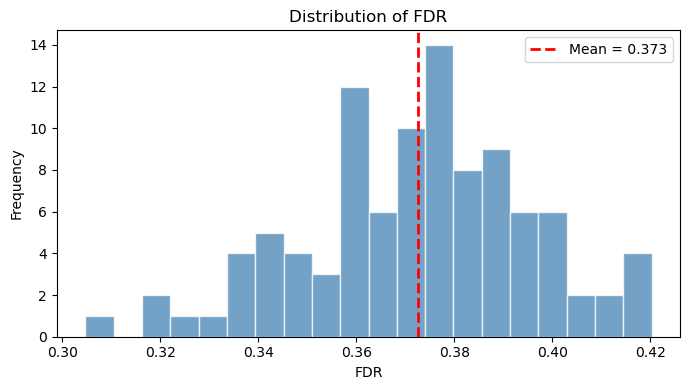

In [ ]:
# Cell 7: Final Analysis and Visualization

fdr_arr = np.asarray(fdr_results, dtype=float)
mean_fdr = float(np.nanmean(fdr_arr)) if fdr_arr.size else float('nan')
std_fdr = float(np.nanstd(fdr_arr)) if fdr_arr.size else float('nan')

print("="*60)
print("FDR ANALYSIS SUMMARY")
print("="*60)
print(f"Prediction-based FDR across {len(fdr_arr)} simulations:")
print(f"  Mean: {mean_fdr:.4f}")
print(f"  Std:  {std_fdr:.4f}")
print(f"  Min:  {np.min(fdr_arr):.4f}")
print(f"  Max:  {np.max(fdr_arr):.4f}")

# Create combined visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# FDR distribution
ax1.hist(fdr_arr, bins=20, alpha=0.75, color='steelblue', edgecolor='white')
ax1.axvline(mean_fdr, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_fdr:.3f}")
ax1.set_xlabel('FDR')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of FDR')
ax1.legend()

# Parameter recovery overview
param_names = ['τ_s', 'τ_u', 'σ_δ_scale', 'δ_corr']
correlations = [tau_s_stats[3], tau_u_stats[3], sigma_delta_scale_stats[3], 1.0 - min(corr_mae, 1.0)]  # Use 1-MAE for correlation matrix
biases = [tau_s_stats[0], tau_u_stats[0], sigma_delta_scale_stats[0], corr_mae]

x_pos = np.arange(len(param_names))
bars = ax2.bar(x_pos, correlations, alpha=0.7, color=['steelblue', 'darkgreen', 'darkorange'])
ax2.set_xlabel('Parameters')
ax2.set_ylabel('Correlation with True Values')
ax2.set_title('Parameter Recovery Correlations')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(param_names)
ax2.set_ylim(0, 1)

# Add bias information as text
for i, (corr, bias) in enumerate(zip(correlations, biases)):
    ax2.text(i, corr + 0.02, f'bias={bias:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('plots/combined_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSimulation completed successfully!")
print(f"Results saved to: plots/fdr_distribution.pdf, plots/parameter_recovery_analysis.pdf, plots/combined_analysis.pdf")
